# Electroencephalogram example

This dataset contains EEG recordings from human neonates. Multi-channel EEG was recorded from 79 term neonates admitted to the neonatal intensive care unit (NICU) at the Helsinki University Hospital. The median recording duration was 74 minutes (IQR: 64 to 96 minutes).

In [1]:
import numpy as np
import pandas as pd
import torch
import mogptk

torch.manual_seed(1);

# MOGP prediction on the sensor values

We use eight of the twenty two sensor's values as channel, leaving us with eight channels to fit using multi output Gaussian processes in order to find cross correlations between the channels. 

In [2]:
dataset_pd = pd.read_csv('data/eeg.csv',header=0,index_col=0)
cols = ['EEG Fp1-Ref','EEG Fp2-Ref','EEG Fz-Ref','EEG Cz-Ref','EEG T3-Ref','EEG T4-Ref','EEG O1-Ref','EEG O2-Ref']
t = dataset_pd['time'].values
y = dataset_pd[cols].values * 1e6

data = mogptk.DataSet()
for i in range(len(cols)):
    data.append(mogptk.Data(t, y[:, i], name=cols[i]))

for i, channel in enumerate(data):
    channel.transform(mogptk.TransformDetrend())
    channel.remove(pct=0.4)
    
    if i not in [0,1, 2, 3, 5, 7]:
        channel.remove_range(45, None)

# simulate sensor failure
data[0].remove_range(25, 35)
data[5].remove_range(None, 10)
data[7].remove_range(None, 10)        

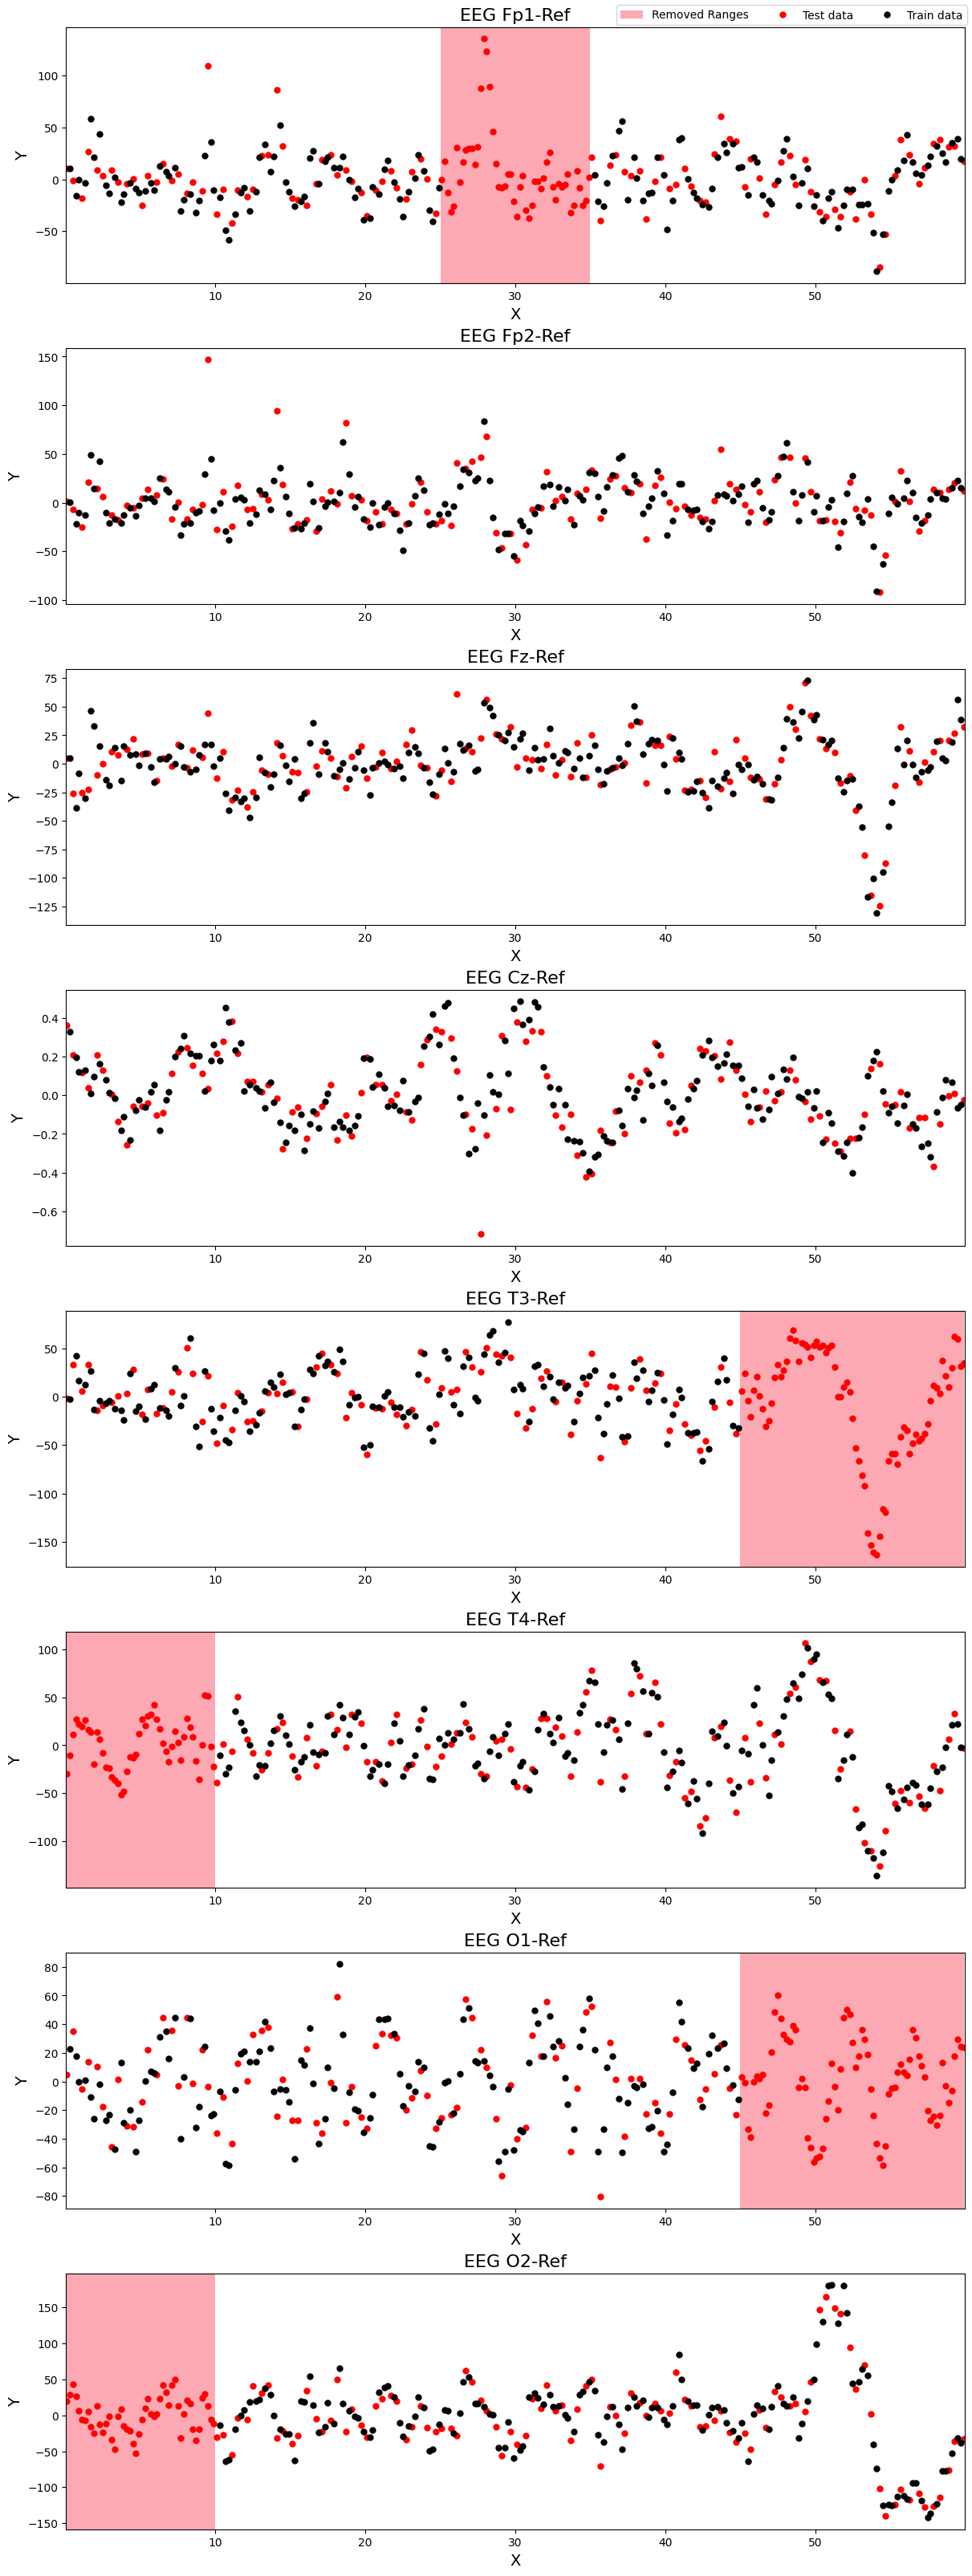

In [3]:
data.plot();

### Model training

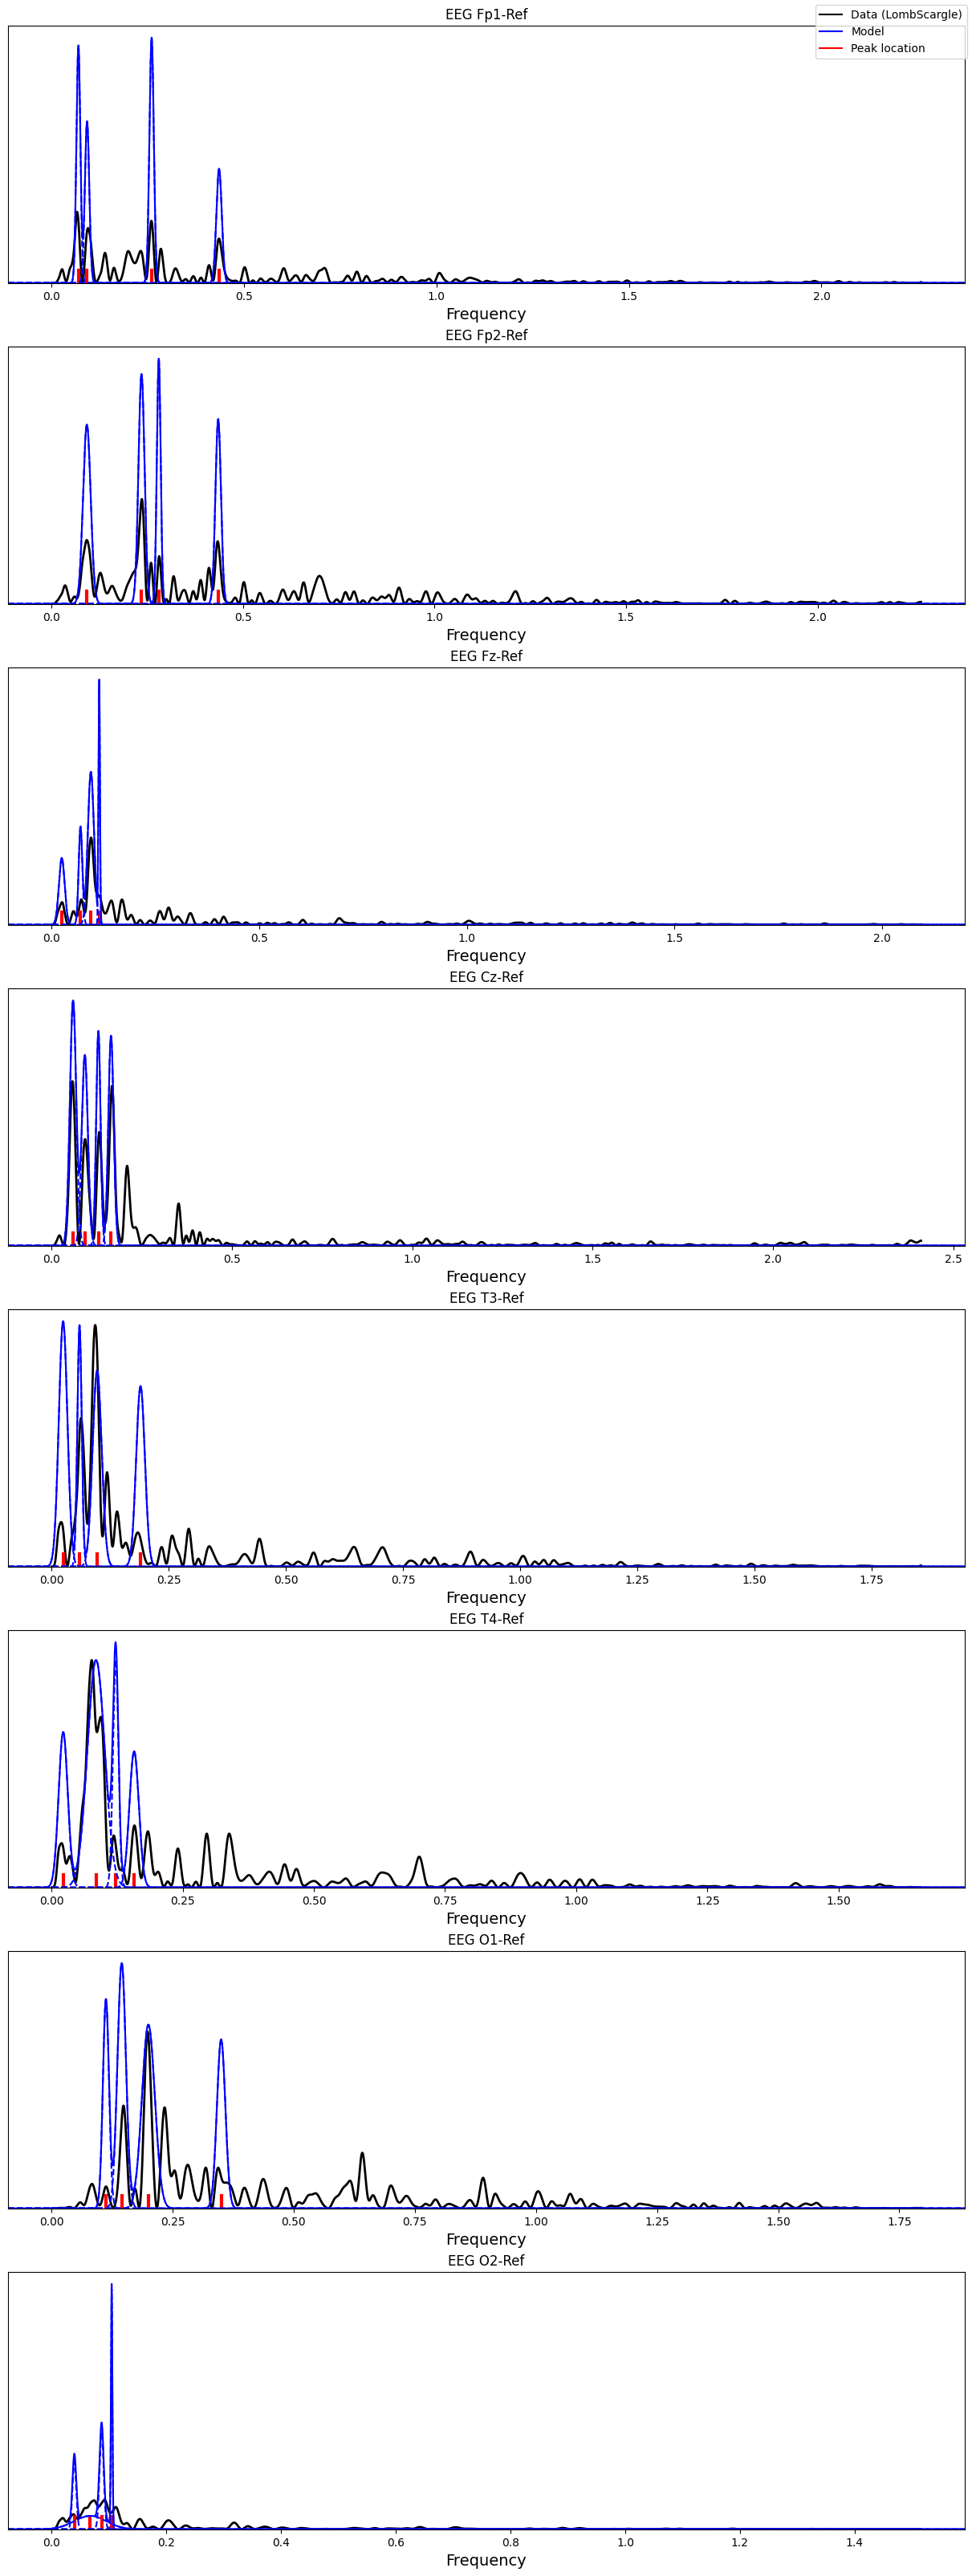

In [4]:
model = mogptk.MOSM(data, Q=4)
model.init_parameters('BNSE')
model.plot_spectrum();

Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: MultiOutputSpectralMixtureKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 8
‣ Parameters: 168
‣ Training points: 1260
‣ Iterations: 1000
     0/1000   0:00:11  loss=     5050.25  error=     20.1488 (warmup)
     2/1000   0:00:50  loss=     5050.07  error=     21.3098
    42/1000   0:01:00  loss=     4974.86  error=     20.6507
    85/1000   0:01:10  loss=     4944.91  error=     20.4311
   128/1000   0:01:20  loss=     4930.77  error=     20.4007
   171/1000   0:01:30  loss=      4923.7  error=     19.7443
   215/1000   0:01:40  loss=     4907.65  error=     20.3172
   258/1000   0:01:50  loss=     4899.85  error=      20.777
   301/1000   0:02:00  loss=     4895.87  error=     20.4546
   344/1000   0:02:10  loss=     4890.05  error=     20.6714
   387/1000   0:02:20  loss=     4887.56  error=     20.7303
   430/1000   0:02:30  loss=      4885.3  error=     20.7466
   473/1000   0:02:40  loss=     4883.68  error=     20.

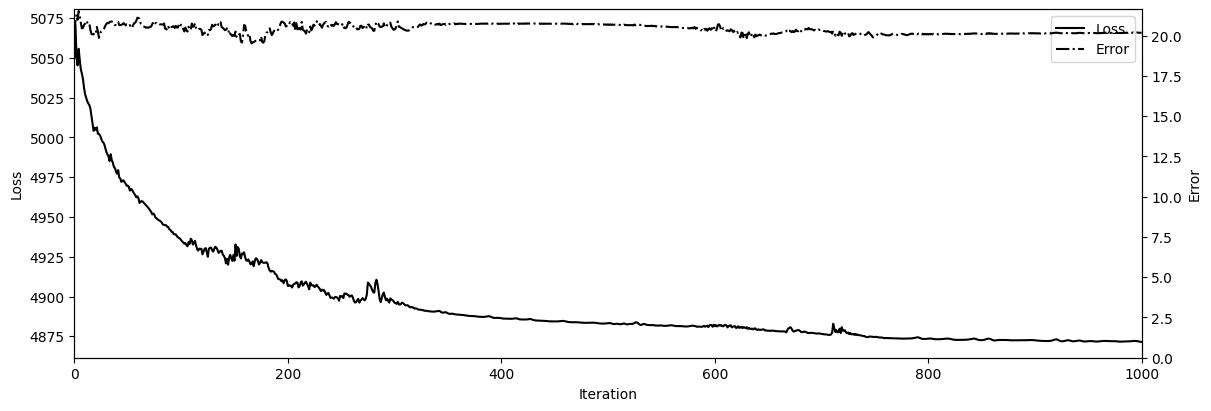

In [5]:
model.train(method='Adam', lr=0.05, iters=1000, verbose=True, error='MAE', plot=True);

### Prediction

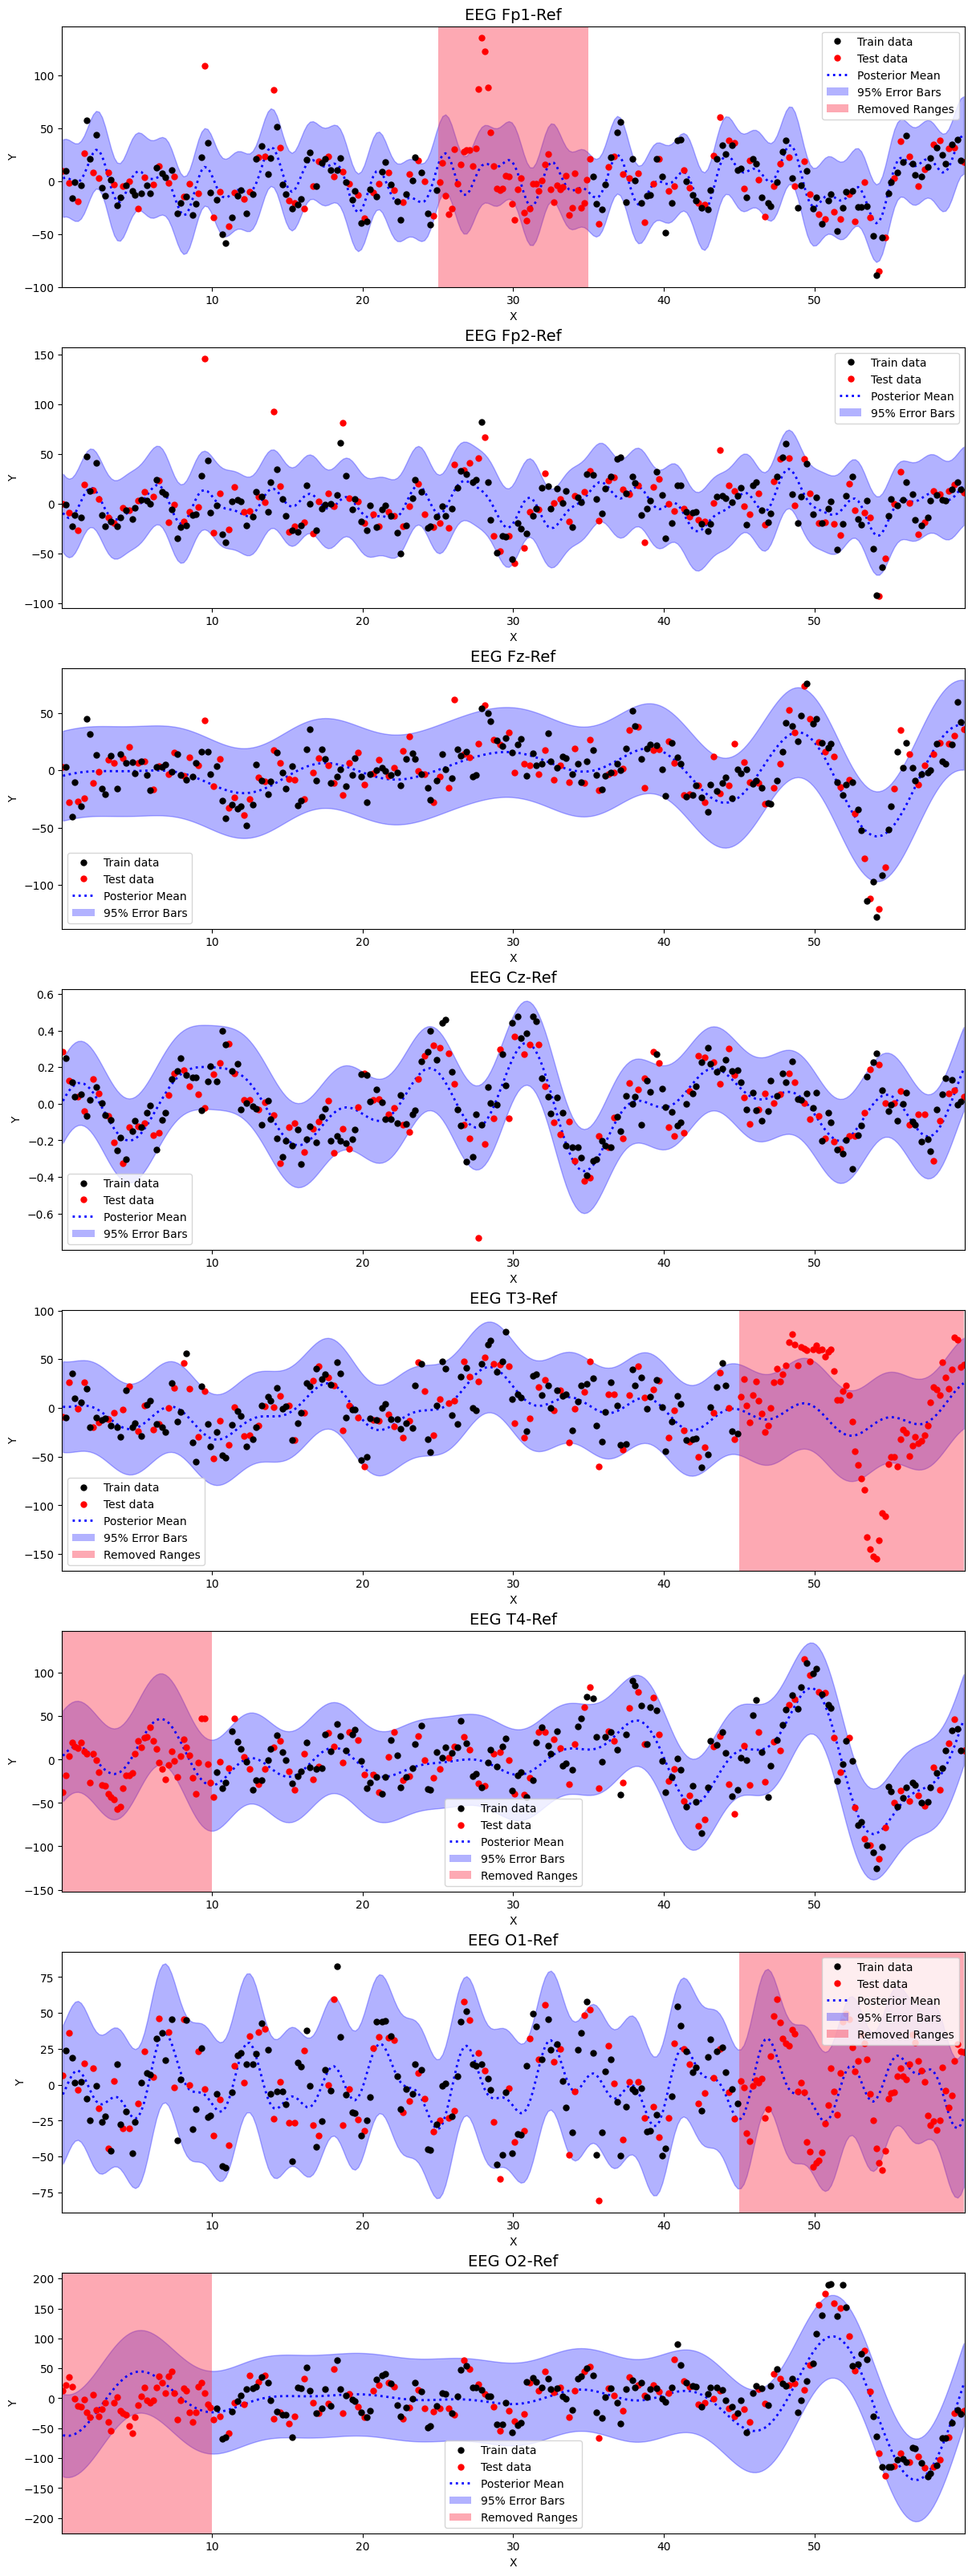

In [6]:
model.plot_prediction(transformed=True);